In [ ]:
# 1. Uninstall the problematic packages
!pip uninstall -y protobuf ray flwr

# 2. Install specific versions compatible with Colab's Python 3.12
# We use ray 2.31.0 (the earliest available for Py 3.12) and protobuf 5.26.1
!pip install "protobuf==5.26.1" "ray[default]==2.31.0" "cryptography==43.0.3"

# 3. Install Flower, Transformers, and Datasets
!pip install -q "flwr[simulation]" torch torchvision transformers datasets

# 4. Final fix for a common Ray-Protobuf bug
import os
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"

# 5. Restart the runtime automatically to apply changes
import os
os.kill(os.getpid(), 9)

Found existing installation: protobuf 6.33.4
Uninstalling protobuf-6.33.4:
  Successfully uninstalled protobuf-6.33.4
Found existing installation: ray 2.51.1
Uninstalling ray-2.51.1:
  Successfully uninstalled ray-2.51.1
Found existing installation: flwr 1.25.0
Uninstalling flwr-1.25.0:
  Successfully uninstalled flwr-1.25.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 118.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 123.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 154.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.3/201.3 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 137.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.4/242.4 kB 8.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
textual 7.3.0 requires rich>=14.2.0, but you have rich 13.9.4 which is incompatible.
pyopenssl 24.2.1 requires cryptography<44,>=41.0.5, but you have cryptography 44.0.3 which is incompatible.
google-ai-generativelanguage 0.6.15 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.2, but you have protobuf 6.33.4 which is incompatible.
tensorflow 2.19.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.3, but you have protobuf 6.33.4 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 6.33.4 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography 44.0.3 which is incompatible.


In [ ]:
import os
import torch
import flwr as fl
import numpy as np
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader
from torch.optim import AdamW
from collections import OrderedDict

# ==========================================
# 1. SETTINGS & CONFIGURATION
# ==========================================
# High-profile choice: DistilBERT is fast but powerful for NLP
CHECKPOINT = "distilbert-base-uncased"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLIENTS = 5
NUM_ROUNDS = 3

print(f"Working on: {DEVICE}")

# ==========================================
# 2. DATA PREPARATION (NLP PIPELINE)
# ==========================================
def load_and_partition_data():
    print("Loading IMDB Dataset and Tokenizing...")
    raw_datasets = load_dataset("imdb")
    tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT)

    def tokenize_fn(examples):
        return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

    # Tokenize and format for PyTorch
    tokenized_datasets = raw_datasets.map(tokenize_fn, batched=True)
    tokenized_datasets = tokenized_datasets.remove_columns(["text"]).rename_column("label", "labels")
    tokenized_datasets.set_format("torch")

    # Use a subset for the demo to save time (5000 train, 1000 test)
    full_train = tokenized_datasets["train"].shuffle(seed=42).select(range(5000))
    full_test = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))

    # Split into Non-IID partitions (Simulating real-world decentralized data)
    partition_size = len(full_train) // NUM_CLIENTS
    partitions = [full_train.shard(num_shards=NUM_CLIENTS, index=i) for i in range(NUM_CLIENTS)]

    return partitions, full_test

partitions, centralized_testset = load_and_partition_data()

# ==========================================
# 3. THE FLOWER CLIENT (The Decentralized Logic)
# ==========================================
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, trainset, testset):
        self.trainset = trainset
        self.testset = testset
        # Each client loads the model to their local memory (GPU or CPU)
        self.model = AutoModelForSequenceClassification.from_pretrained(CHECKPOINT, num_labels=2).to(DEVICE)

    def get_parameters(self, config):
        return [val.cpu().numpy() for _, val in self.model.state_dict().items()]

    def set_parameters(self, parameters):
        params_dict = zip(self.model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
        self.model.load_state_dict(state_dict, strict=True)

    def fit(self, parameters, config):
        self.set_parameters(parameters)
        trainloader = DataLoader(self.trainset, batch_size=16, shuffle=True)
        optimizer = AdamW(self.model.parameters(), lr=5e-5)

        self.model.train()
        for epoch in range(1): # Local training for 1 epoch
            for batch in trainloader:
                batch = {k: v.to(DEVICE) for k, v in batch.items()}
                optimizer.zero_grad()
                loss = self.model(**batch).loss
                loss.backward()
                optimizer.step()

        return self.get_parameters(config={}), len(self.trainset), {}

    def evaluate(self, parameters, config):
        self.set_parameters(parameters)
        testloader = DataLoader(self.testset, batch_size=16)
        self.model.eval()
        correct, total, loss = 0, 0, 0.0
        with torch.no_grad():
            for batch in testloader:
                batch = {k: v.to(DEVICE) for k, v in batch.items()}
                outputs = self.model(**batch)
                loss += outputs.loss.item()
                predictions = torch.argmax(outputs.logits, dim=-1)
                correct += (predictions == batch["labels"]).sum().item()
                total += batch["labels"].size(0)

        accuracy = correct / total
        return float(loss / len(testloader)), len(self.testset), {"accuracy": float(accuracy)}

# ==========================================
# 4. SERVER STRATEGY & SIMULATION
# ==========================================
def client_fn(cid: str):
    return FlowerClient(partitions[int(cid)], centralized_testset)

# High-profile: Using FedProx handles variations in client data/hardware better than FedAvg
strategy = fl.server.strategy.FedProx(
    proximal_mu=0.1,
    fraction_fit=0.5,      # Train 50% of clients each round
    min_fit_clients=2,
    min_available_clients=NUM_CLIENTS,
)

# Start Simulation
print("\n Starting Federated Simulation...")
history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_ROUNDS),
    strategy=strategy,
    # Managing resources: 2 clients can share the GPU at once
    client_resources={"num_cpus": 1, "num_gpus": 0.5 if torch.cuda.is_available() else 0.0},
)

print("\n Training Complete!")

Working on: cuda
Loading IMDB Dataset and Tokenizing...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]


🚀 Starting Federated Simulation...


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

          


✅ Training Complete!


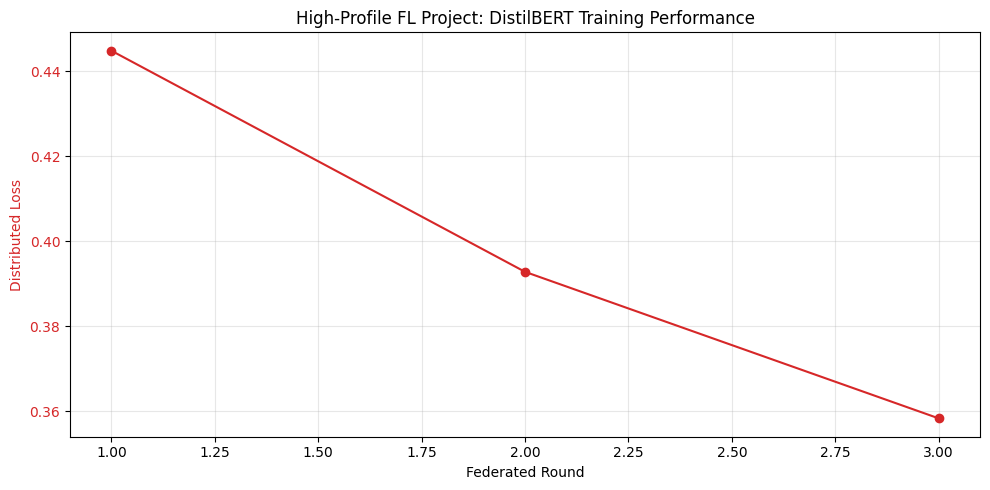

In [ ]:
import matplotlib.pyplot as plt

# 1. Extract Distributed Loss
rounds, losses = zip(*history.losses_distributed)

# 2. Extract Distributed Accuracy (if available)
# If your evaluate function returned accuracy, it will be here:
if "accuracy" in history.metrics_distributed:
    rounds_acc, accs = zip(*history.metrics_distributed["accuracy"])
else:
    accs = None

# Create Plot
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot Loss
ax1.set_xlabel('Federated Round')
ax1.set_ylabel('Distributed Loss', color='tab:red')
ax1.plot(rounds, losses, marker='o', color='tab:red', label='Loss')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.grid(True, alpha=0.3)

# Plot Accuracy on the same graph (if available)
if accs:
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy', color='tab:blue')
    ax2.plot(rounds_acc, accs, marker='s', color='tab:blue', label='Accuracy')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

plt.title('High-Profile FL Project: DistilBERT Training Performance')
fig.tight_layout()
plt.show()